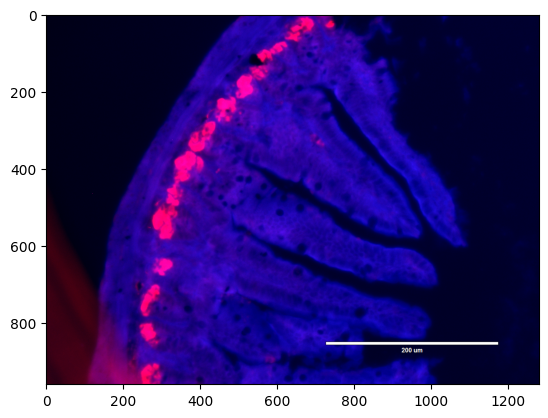

In [14]:

import os
import sys
import tifffile as tiff
import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

sys.path.append("/home/phillip/documents/lysozyme")
import src
from src.lysozyme_stain_quantification.crypts.identify_potential_crypts_ import identify_potential_crypts

from src.lysozyme_stain_quantification.crypts.remove_edge_touching_regions_mod import remove_edge_touching_regions_sk
from src.lysozyme_stain_quantification.crypts.scoring_selector_mod import scoring_selector

max_regions = 5
paths_of_interest = {
    "edge_cut_off_case": "/home/phillip/documents/lysozyme/lysozyme images/Retake G2 - ABX/G2FB - 2 RETAKE.tif",
    "another_case": "/home/phillip/documents/lysozyme/lysozyme images/Retake G2 - ABX/G2FB - 3 RETAKE.tif",
    "original case": "/home/phillip/documents/lysozyme/lysozyme images/Jej LYZ/G2/G2FL - 3.tif"
}
image = tiff.imread(paths_of_interest["original case"])#"/home/phillip/documents/lysozyme/lysozyme images/Jej LYZ/G2/G2FL - 3.tif")
plt.imshow(image)
rfp = image[...,0]
dapi = image[...,2]


regions = remove_edge_touching_regions_sk(identify_potential_crypts(
    crypt_img=rfp,
    tissue_image=dapi,
    blob_size_px=int(50.0 * 0.4476),

))
subject = rfp

In [21]:
import numpy as np
from skimage.filters import threshold_otsu
from skimage.morphology import local_maxima, dilation
from skimage.util import invert

from skimage.morphology import white_tophat, disk
from numpy.typing import NDArray
import cv2
import scipy.ndimage as ndi
from skimage.feature import match_template
from skimage.restoration import inpaint
def effective_label_count_by_values(
    labels: np.ndarray,
    values: np.ndarray,
    region_mask: np.ndarray | None = None,
    bg_label: int = 0,
    value_agg: str = "sum_positive",   # "sum_positive" | "sum_abs" | "sum"
    eps: float = 1e-12,
):
    """
    labels: int array (H,W), 0/`bg_label` = background, >0 = label ids
    values: float array (H,W), scalar image whose mass each label 'owns'
    region_mask: optional bool (H,W) to restrict the fixed region
    value_agg:
        - "sum_positive": sum(max(values, 0)) per label (default; ignores negatives)
        - "sum_abs": sum(abs(values)) per label
        - "sum": raw sum(values) per label (can be negative; will be shifted if needed)
    Returns dict with:
        K_raw          : number of labels present in region (excl. bg)
        masses         : per-label masses (aligned to present_labels)
        present_labels : sorted label ids considered (>0)
        p              : normalized shares per label
        Neff_simpson   : 1 / sum p^2
        Neff_shannon   : exp(-sum p log p)
        evenness       : Neff_simpson / K_raw  (in [0,1])
    """
    if region_mask is None:
        region_mask = np.ones_like(labels, dtype=bool)

    # Select region & finite values
    m = region_mask & np.isfinite(values)
    lab = labels[m]
    val = values[m]

    # Exclude background
    sel = lab != bg_label
    if not np.any(sel):
        return {
            "K_raw": 0, "masses": np.array([]), "present_labels": np.array([]),
            "p": np.array([]), "Neff_simpson": 0.0, "Neff_shannon": 0.0, "evenness": np.nan
        }

    lab = lab[sel]
    val = val[sel]

    # Choose how to aggregate values into mass
    if value_agg == "sum_positive":
        w = np.maximum(val, 0.0)
    elif value_agg == "sum_abs":
        w = np.abs(val)
    elif value_agg == "sum":
        w = val
    else:
        raise ValueError("value_agg must be 'sum_positive', 'sum_abs', or 'sum'")

    # Map possibly sparse label ids to contiguous bins via bincount
    present = np.unique(lab)
    max_id = int(present.max())
    masses_full = np.bincount(lab, weights=w, minlength=max_id + 1)
    masses = masses_full[present]

    # If raw "sum" gave negatives or zero total, shift to be nonnegative
    total = masses.sum()
    if value_agg == "sum" and total <= 0:
        shift = -masses.min() + eps
        masses = masses + shift
        total = masses.sum()

    # Guard: if still zero, return zeros
    if total <= 0:
        return {
            "K_raw": present.size, "masses": masses, "present_labels": present,
            "p": np.zeros_like(masses), "Neff_simpson": 0.0, "Neff_shannon": 0.0, "evenness": 0.0
        }

    p = masses / total
    Neff_simpson = 1.0 / np.sum(p * p)
    Neff_shannon = float(np.exp(-np.sum(p * np.log(p + eps))))
    evenness = Neff_simpson / present.size if present.size > 0 else np.nan

    return {
        "K_raw": int(present.size),
        "masses": masses,
        "present_labels": present,
        "p": p,
        "Neff_simpson": Neff_simpson,
        "Neff_shannon": Neff_shannon,
        "evenness": evenness,
    }
scores = effective_label_count_by_values(
    labels=regions,
    values=rfp,
)

weights = {
        "circularity": 0.15,  # Most important - want circular regions
        "area": 0.25,         # Second - want consistent sizes
        "line_fit": 0.20,     # Moderate - want aligned regions
        "red_intensity": 0.55,  # Moderate - want bright regions
        
        }
medium_crypts, crypt_scores = scoring_selector(
        label_img=regions,
        raw_img=rfp,
        max_regions=scores["Neff_simpson"],
        return_details=True,
        weights=weights
    )
#print(crypt_scores['properties_df'])

best_crypts, best_crypt_scores = scoring_selector(
        label_img=medium_crypts,
        raw_img=rfp,
        max_regions=5,
        return_details=True,
        weights=weights
    )

def minmax256(arr: np.ndarray):
    arr = arr.astype(np.float32)
    arr = (255*(arr - np.min(arr)) / (np.max(arr) - np.min(arr)) )
    return arr.astype(np.uint8)
def quantify_matches(detections: np.ndarray, index: int, matching_image: np.ndarray[np.uint], pad_input=True):
    #template_boundaries = find_boundaries(detections == index)
    slc = ndi.find_objects(detections == index)[0]

    crypt_binary = detections == index if matching_image.ndim == 2 else np.stack([detections == index]*matching_image.shape[-1], axis=-1)
    template = np.where(crypt_binary, matching_image, np.zeros_like(matching_image))
    template = template[slc]
    result = match_template(matching_image, template, pad_input=pad_input)
    
    result = inpaint.inpaint_biharmonic(result, detections == index, channel_axis=None)
    result = np.maximum(result, 0)  # Collapse channel axis if present
    result = minmax256(result) # Normalize to 255
    result = result.astype(np.uint16)
    return result, template, slc
def create_match_stack(best_crypts, matching_image)-> tuple[np.ndarray[np.int_], list[tuple[slice,...]]]:
    match_arrays = []
    slcs = []
    for crypt_index in range(1, np.max(best_crypts)+1):
        result, template, slc = quantify_matches(best_crypts, crypt_index, matching_image, pad_input=True)
        match_arrays.append(result)
        slcs.append(slc)

    return match_arrays, slcs 

result_stack, slcs = create_match_stack(medium_crypts, subject)

result_array = np.array(result_stack)
weights_array = np.array(best_crypt_scores['properties_df']['quality_score'])

# Calculate weighted geometric mean manually since gmean with weights is having broadcasting issues
# Use the formula: exp(sum(w_i * log(x_i)) / sum(w_i))
log_results = np.log(np.maximum(result_array, 1))  # avoid log(0)
weighted_log_sum = (invert(np.sum(weights_array[:, np.newaxis, np.newaxis] * log_results, axis=0)))
weight_sum = np.sum(weights_array)
collapsed_results = np.exp(weighted_log_sum / weight_sum).astype(np.uint16)


def opencv_dilate_disk(img, r):
    k = 2*r + 1
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    # OpenCV likes uint8/float32; keep float32 if you want

    return cv2.dilate(img, se)

def caps(image, small_r, big_r):
    image1 = image - white_tophat(image, disk(small_r))
    #selem_small, selem_large = disk(small_r), disk(big_r)    
    hats = opencv_dilate_disk(image1, big_r) - opencv_dilate_disk(image1, small_r) 
    clean = image1 - np.minimum(image1, hats) 
    troughs = np.maximum(image1, hats) - image1
    return hats, clean, troughs
#cell_hats = caps(b_eq, 2, 20)

hats, clean, troughs = caps(collapsed_results, 2, 20)

otsu_thresh = threshold_otsu(clean)
binary_clean = clean > otsu_thresh
labeled_binary_clean, num_features_bin = ndi.label(binary_clean)
labeled_binary_clean_overlap_with_best_crypts = np.where(best_crypts > 0, labeled_binary_clean, 0)
# then how do i dump out the names of those labels
unique_labels = np.unique(labeled_binary_clean_overlap_with_best_crypts)
print("Unique labels in best crypts:", unique_labels)
# now show the selected labels from labeled_binary_clean
selected_labels_mask = np.isin(labeled_binary_clean, unique_labels)
selected_labels = np.where(selected_labels_mask, labeled_binary_clean, 0)
def effective_label_count(labels: np.ndarray, region_mask: np.ndarray=None, eps: float=1e-12):
    """
    labels: int array (0 = background; 1..K = labels)
    region_mask: optional bool array selecting the fixed region of interest
    returns:
      K (raw unique count in region, excl. background),
      Neff_simpson (1 / sum p_i^2),
      Neff_shannon (exp(-sum p_i log p_i)),
      ratio_simpson (Neff_simpson / K) or np.nan if K==0
    """
    if region_mask is None:
        region_mask = np.ones_like(labels, dtype=bool)

    sel = labels[region_mask]
    sel = sel[sel > 0]  # drop background

    if sel.size == 0:
        return 0, 0.0, 0.0, np.nan

    K = int(np.unique(sel).size)

    # areas per label (compact, zero-based after excluding bg)
    max_lab = int(sel.max())
    counts = np.bincount(sel, minlength=max_lab + 1)[1:]  # drop index 0 (bg)
    counts = counts[counts > 0]  # keep only present labels
    total = counts.sum()
    p = counts / total

    Neff_simpson = 1.0 / np.sum(p * p)
    Neff_shannon = float(np.exp(-np.sum(p * np.log(p + eps))))
    ratio_simpson = Neff_simpson / K if K > 0 else np.nan

    return K, Neff_simpson, Neff_shannon, ratio_simpson
K, Neff_simpson, Neff_shannon, ratio_simpson = effective_label_count(selected_labels)
print(f"Effective label count in selected labels: K={K}, Neff_simpson={Neff_simpson}, Neff_shannon={Neff_shannon}, ratio_simpson={ratio_simpson}")

# only trust the simpson number here, also need to add a solution where we add in the crypt selection boundaries that include the new regions, as they will have soe of the extra data missing, ( tho do need to solve issue of accidentally including unwanted crypts)

Unique labels in best crypts: [ 0  1 64]
Effective label count in selected labels: K=2, Neff_simpson=1.0151718417314488, Neff_shannon=1.0453073698019626, ratio_simpson=0.5075859208657244


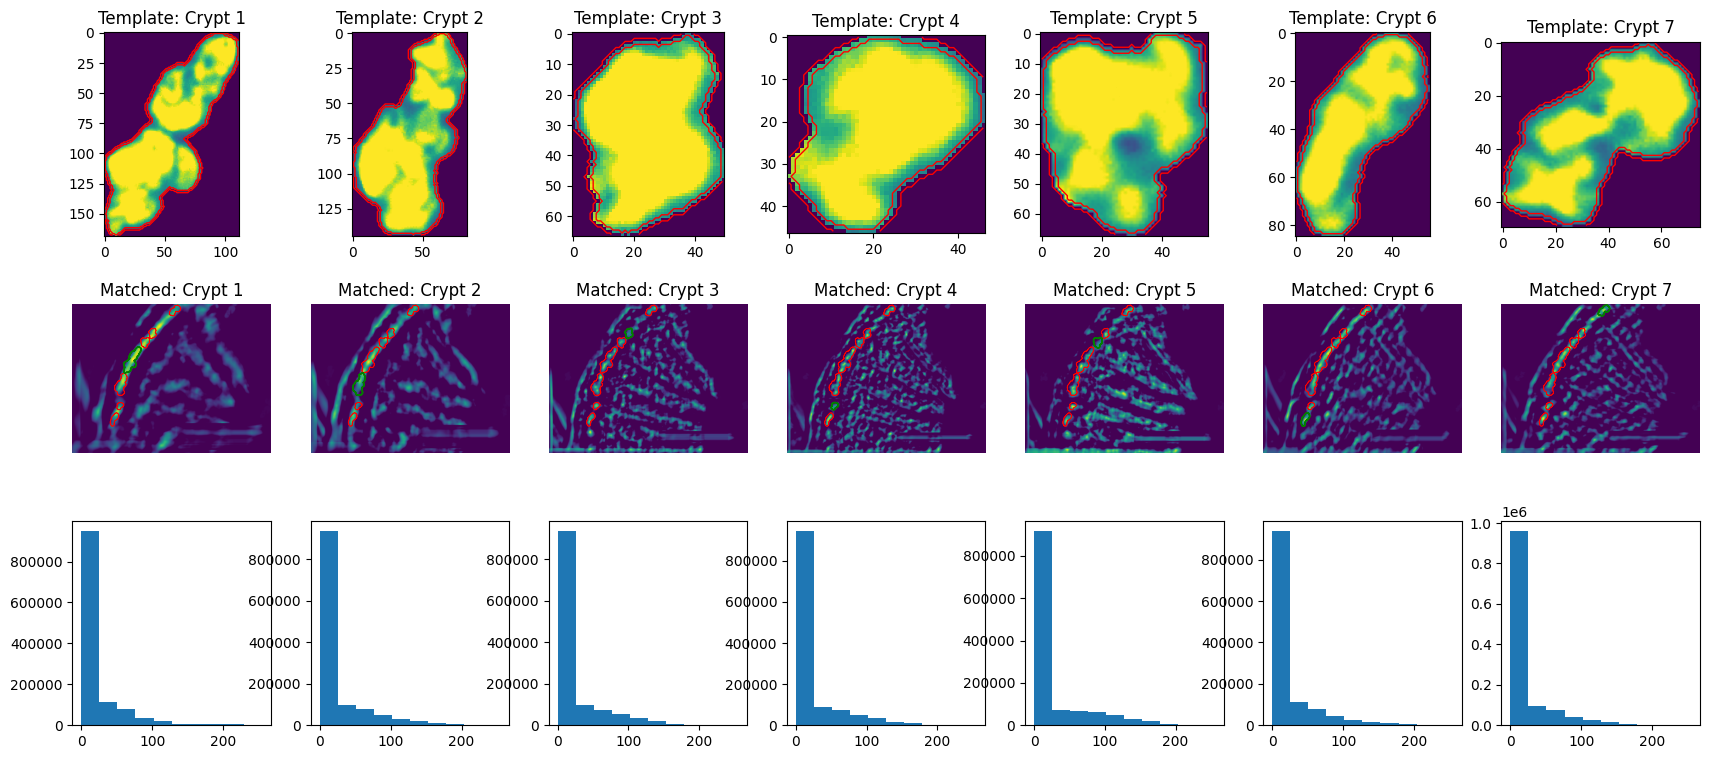

In [16]:
num_crypts = np.max(medium_crypts)
fig, ax = plt.subplots(3,num_crypts, figsize=(3*len(result_stack),9))
subject = rfp
boundaries = find_boundaries(medium_crypts)


for crypt_index, (match_array, slc) in enumerate(zip(result_stack, slcs)):

    
    
    
    #ax[crypt_index, 0].imshow(mark_boundaries(subject, best_crypts==(crypt_index+1))[slc])
    ax[0, crypt_index].imshow(np.where(medium_crypts==(crypt_index+1), subject, 0)[slc])
    ax[0, crypt_index].contour(find_boundaries(medium_crypts==(crypt_index+1))[slc], colors='r', linewidths=1)
    ax[0, crypt_index].set_title(f"Template: Crypt {crypt_index+1}")
    
    ax[1, crypt_index].imshow(match_array)
    ax[1, crypt_index].contour(boundaries, colors='r', linewidths=0.5)
    ax[1, crypt_index].axis('off')
    ax[1, crypt_index].contour(find_boundaries(medium_crypts==(crypt_index+1)), colors='g', linewidths=1)
    

    ax[1, crypt_index].set_title(f"Matched: Crypt {crypt_index+1}")
    ax[2, crypt_index].hist(match_array.flatten())
    #ax[crypt_index, 2].imshow(match_template(slc, best_crypts, pad_input=True))



plt.show()

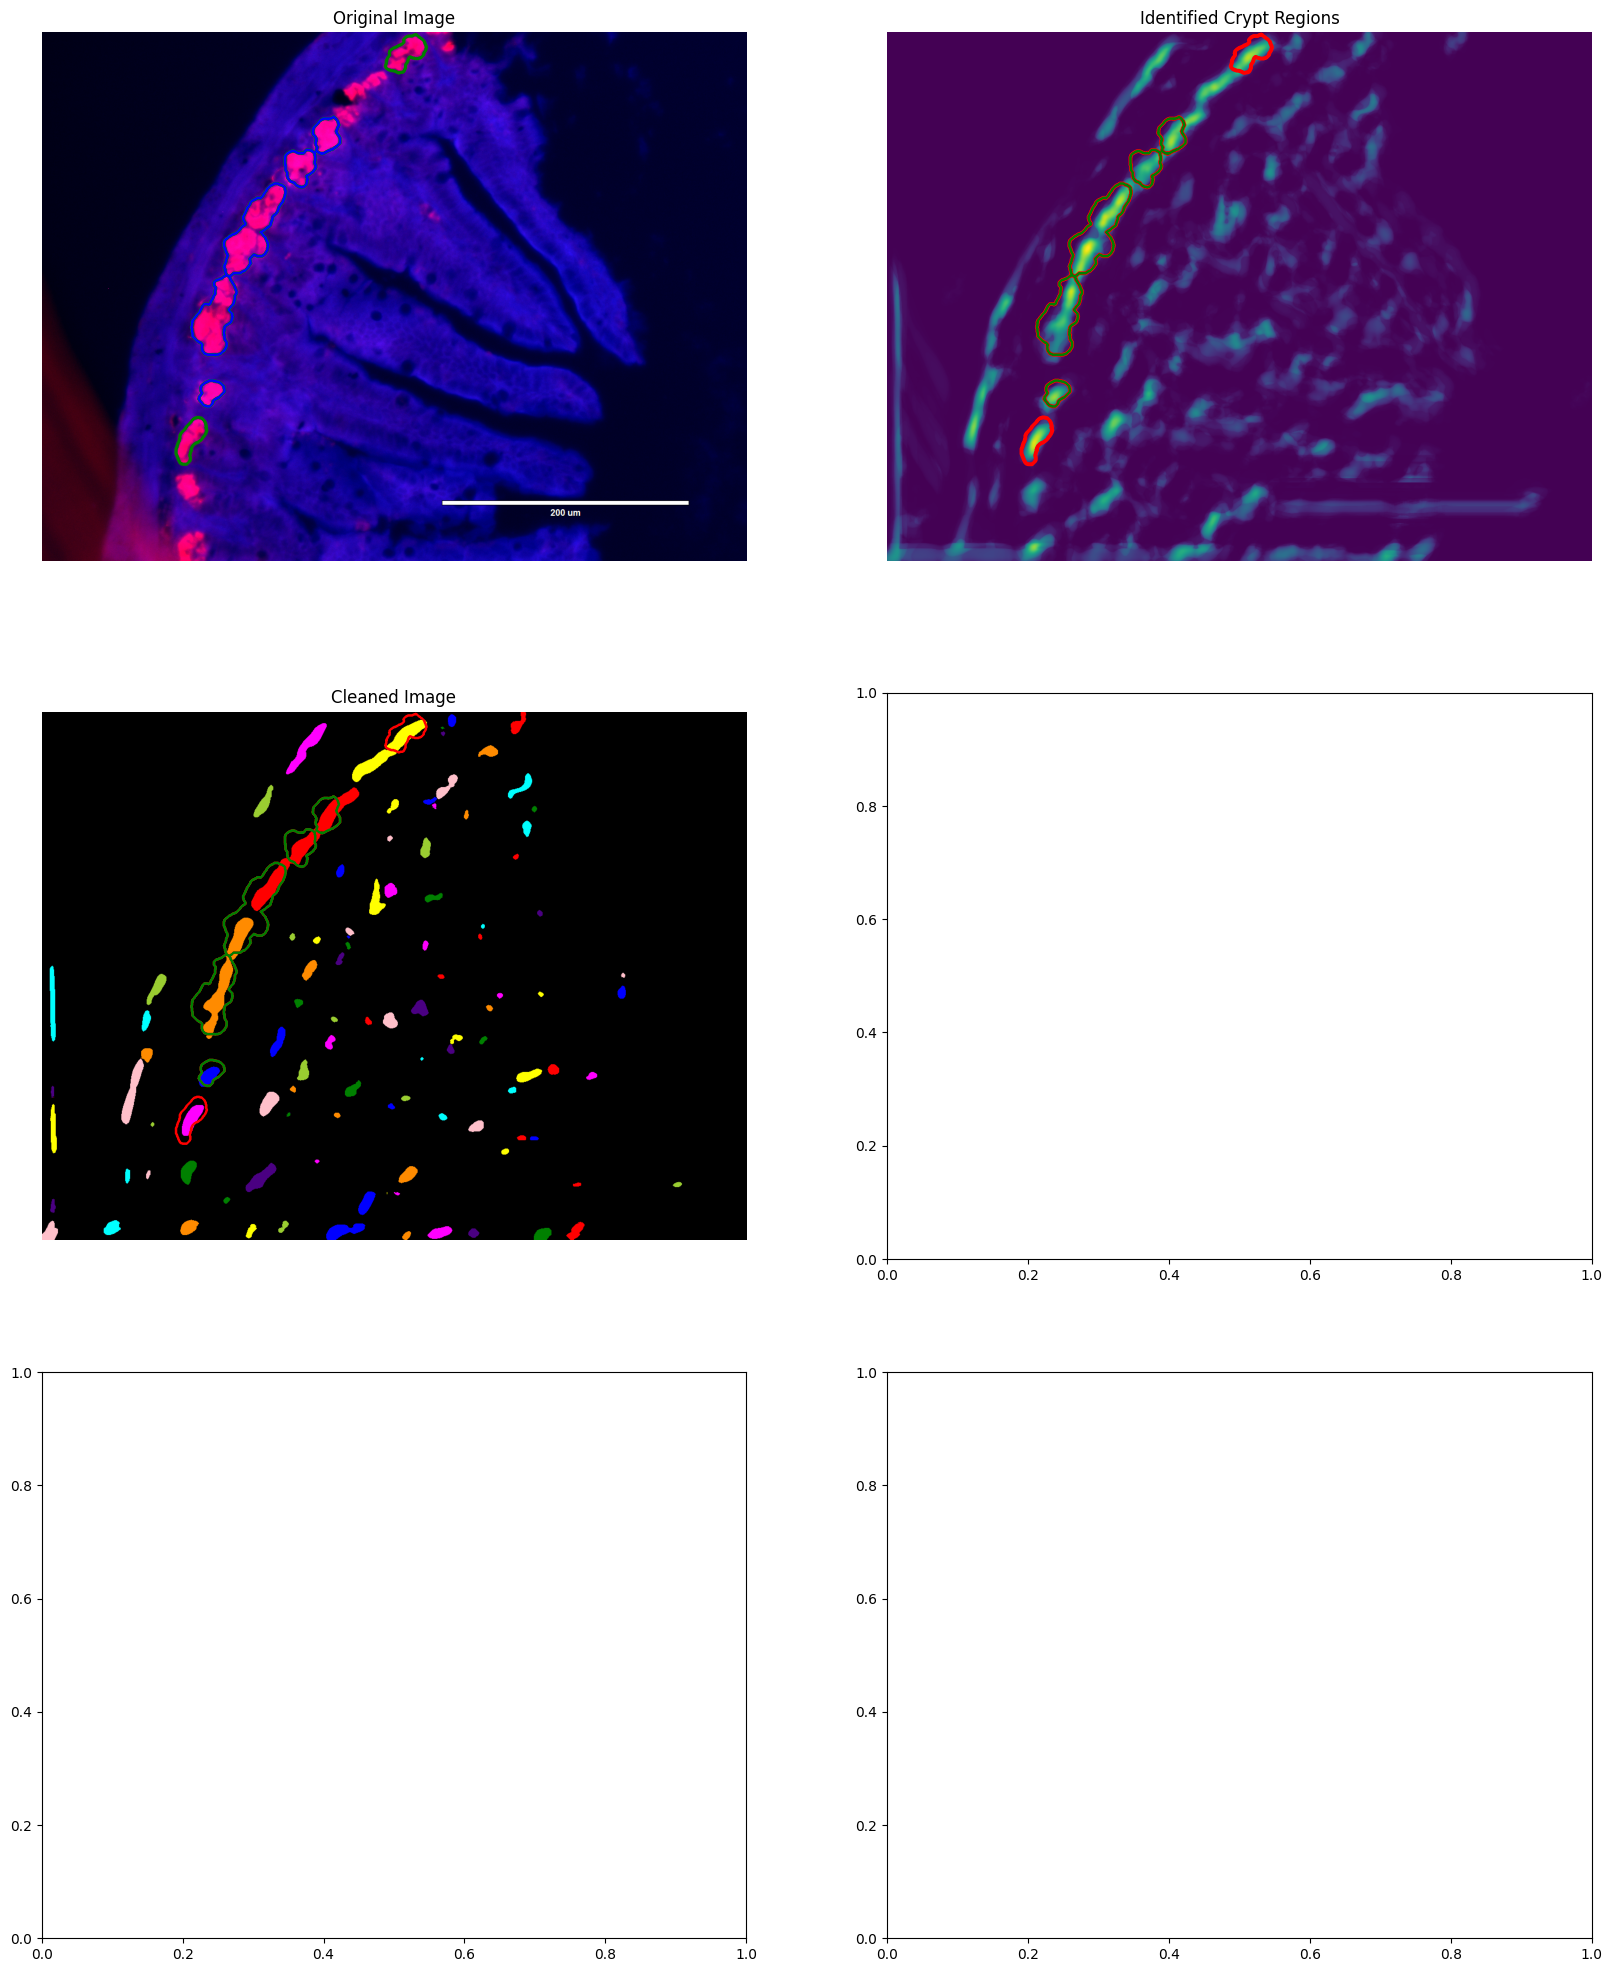

In [17]:


from skimage.color import label2rgb

medium_crypts_boundaries = find_boundaries(medium_crypts)
best_crypts_boundaries = find_boundaries(best_crypts)
fig, axs = plt.subplots(3,2, figsize=(20,25))
axs[0,0].imshow(image); axs[0,0].set_title("Original Image"); axs[0,0].axis('off'); axs[0,0].contour(medium_crypts_boundaries, colors='g', linewidths=1.5); axs[0,0].contour(best_crypts_boundaries, colors='b', linewidths=1)
axs[0,1].imshow(collapsed_results); axs[0,1].set_title("Identified Crypt Regions"); axs[0,1].axis('off'); axs[0,1].contour(medium_crypts_boundaries, colors='r', linewidths=2); axs[0,1].contour(best_crypts_boundaries, colors='g', linewidths=1)

# all found peaks
axs[1,0].imshow(label2rgb(labeled_binary_clean)); axs[1,0].set_title("Cleaned Image"); axs[1,0].axis('off'); axs[1,0].contour(medium_crypts_boundaries, colors='r', linewidths=1); axs[1,0].contour(best_crypts_boundaries, colors='g', linewidths=1)
#axs[1,0].contour(find_bondaries(selected_labels), colors='r', linewidths=1)
#axs[1,1].imshow(label2rgb())

# axs[1,0].imshow(label2rgb(selected_labels)); axs[1,0].set_title("Cleaned Image"); axs[1,0].axis('off'); axs[1,0].contour(medium_crypts_boundaries, colors='r', linewidths=1); axs[1,0].contour(best_crypts_boundaries, colors='g', linewidths=1)


Unique labels in best crypts: [ 0 11 27 62]
Effective label count in selected labels: K=3, Neff_simpson=2.2624499385245445, Neff_shannon=2.452230367493381, ratio_simpson=0.7541499795081815


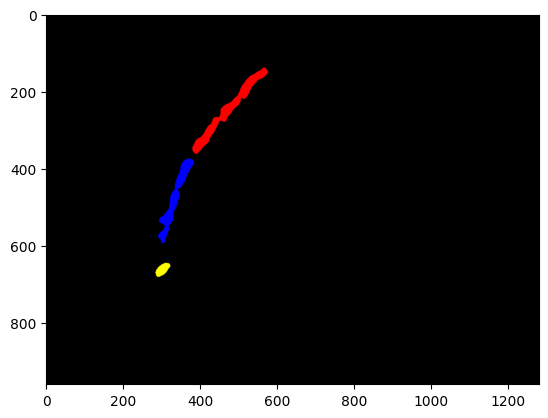

In [18]:
# import tuple
from typing import Literal, Tuple, Optional
hats, clean, troughs = caps(collapsed_results, 2, 20)

otsu_thresh = threshold_otsu(clean)
binary_clean: NDArray[np.bool_] = clean > otsu_thresh
labeled_binary: tuple[NDArray, int] | Literal[1, 0] = ndi.label(binary_clean)
if isinstance(labeled_binary, tuple):
    labeled_binary_clean, num_features_bin = labeled_binary
else: 
    raise ValueError("labeled_binary is not a tuple")
labeled_binary_clean_overlap_with_best_crypts = np.where(best_crypts > 0, labeled_binary_clean, 0)
# then how do i dump out the names of those labels
unique_labels = np.unique(labeled_binary_clean_overlap_with_best_crypts)
print("Unique labels in best crypts:", unique_labels)
# now show the selected labels from labeled_binary_clean
selected_labels_mask = np.isin(labeled_binary_clean, unique_labels)
selected_labels = np.where(selected_labels_mask, labeled_binary_clean, 0)
def effective_label_count(labels: np.ndarray, region_mask: Optional[np.ndarray]=None, eps: float=1e-12):
    """
    labels: int array (0 = background; 1..K = labels)
    region_mask: optional bool array selecting the fixed region of interest
    returns:
      K (raw unique count in region, excl. background),
      Neff_simpson (1 / sum p_i^2),
      Neff_shannon (exp(-sum p_i log p_i)),
      ratio_simpson (Neff_simpson / K) or np.nan if K==0
    """
    if region_mask is None:
        region_mask = np.ones_like(labels, dtype=bool)

    sel = labels[region_mask]
    sel = sel[sel > 0]  # drop background

    if sel.size == 0:
        return 0, 0.0, 0.0, np.nan

    K = int(np.unique(sel).size)

    # areas per label (compact, zero-based after excluding bg)
    max_lab = int(sel.max())
    counts = np.bincount(sel, minlength=max_lab + 1)[1:]  # drop index 0 (bg)
    counts = counts[counts > 0]  # keep only present labels
    total = counts.sum()
    p = counts / total

    Neff_simpson = 1.0 / np.sum(p * p)
    Neff_shannon = float(np.exp(-np.sum(p * np.log(p + eps))))
    ratio_simpson = Neff_simpson / K if K > 0 else np.nan

    return K, Neff_simpson, Neff_shannon, ratio_simpson
K, Neff_simpson, Neff_shannon, ratio_simpson = effective_label_count(selected_labels)
print(f"Effective label count in selected labels: K={K}, Neff_simpson={Neff_simpson}, Neff_shannon={Neff_shannon}, ratio_simpson={ratio_simpson}")
plt.imshow(label2rgb(selected_labels))